In [113]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version
import matplotlib

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [114]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [115]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='random.gsd')


In [116]:
volume = 4 / 3 * (math.pi * (1**3))
initial_volume = simulation.state.N_particles * volume 
initial_volume_fraction = initial_volume / simulation.state.box.volume 
initial_volume

452.38934211693015

In [117]:
initial_volume_fraction

0.3907909228955233

In [118]:
simulation.state.box.volume

1157.625

In [119]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape['A'] = dict(diameter=2)
simulation.operations.integrator = mc

In [124]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.8
final_box_volume = simulation.state.N_particles * volume / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box
)

In [125]:
simulation.operations.updaters.append(compress)

In [126]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.4,
    trigger=periodic,
    max_translation_move=1,
)
simulation.operations.tuners.append(tune)

In [127]:
simulation.state.box.volume 

1157.625

In [128]:
while not compress.complete and simulation.timestep < 1e6:
    simulation.run(1000)
    current_box = simulation.state.box
    current_volume_fraction = (
        simulation.state.N_particles * volume / current_box.volume
    )
    print(f"Current volume fraction: {current_volume_fraction}")

Current volume fraction: 0.3907909228955233


In [129]:
simulation.timestep

11000

In [130]:
if not compress.complete:
    message = 'Compression failed to complete'
    raise RuntimeError(message)

In [131]:
mc.d['A']

0.3015252427441679

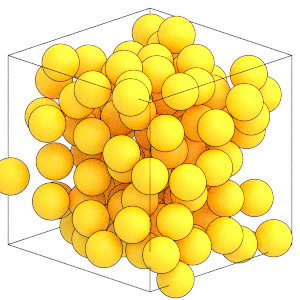

In [132]:
render(simulation.state.get_snapshot())

In [133]:
mc.overlaps

0

In [134]:
final_volume_fraction

0.8

In [135]:
simulation.state.box.volume 

1157.625

In [136]:
mc.type_shapes

[{'type': 'Sphere', 'diameter': 2}]

In [137]:
final_volume = simulation.state.N_particles * volume 
final_volume_fraction1 = final_volume / simulation.state.box.volume 
final_volume_fraction1

0.3907909228955233

In [139]:
box_volume = volume * simulation.state.N_particles / 0.8
box_volume

565.4866776461627

In [17]:
fn = os.path.join(os.getcwd(), 'compressed.gsd')
![ -e "$fn" ] && rm "$fn"

hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='compressed.gsd')